### 2025 Theme: Pre-snap to post-snap predictions
NFL offenses have 40 seconds in which to run a play. That time begins with substitutions, as players run on and off the field until both teams' personnel are configured. It continues into the play call, where both the offensive and defensive units learn their formation and assignments. It ends with myriad strategic decisions by the 22 players on the field, including motion, shifts, and alignment changes, designed to both confuse the opponent and capitalize on any advantages.

In all that action prior to the snap, both teams likely divulge patterns in what players will do after the snap. The goal of this year's competition aims to tell us just what those patterns are.
#### Examples to consider
Your challenge is generating actionable, practical, and novel insights from player tracking data corresponding to pre-snap team and player tendencies. Examples include, but are not limited to:

- Play prediction (run v pass)
- Scheme prediction (blitzes, run fits, route combinations, etc)
- Player prediction (pass patterns, blocking assignments, etc)

Note that the above list is not exhaustive, and we encourage participants to be creative with their submissions.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Load each dataset
games = pd.read_csv('games.csv')
player_play = pd.read_csv('player_play.csv')
players = pd.read_csv('players.csv')
plays = pd.read_csv('plays.csv')

# Load weekly data
week1 = pd.read_csv('tracking_week_1.csv')
week2 = pd.read_csv('tracking_week_2.csv')
week3 = pd.read_csv('tracking_week_3.csv')
week4 = pd.read_csv('tracking_week_4.csv')

In [3]:
# Checking for NULL data
## nflId, jerseynumber, o, dir are all null for the ball locations/rows on the play
plays.isnull().sum()

gameId                                  0
playId                                  0
playDescription                         0
quarter                                 0
down                                    0
yardsToGo                               0
possessionTeam                          0
defensiveTeam                           0
yardlineSide                          224
yardlineNumber                          0
gameClock                               0
preSnapHomeScore                        0
preSnapVisitorScore                     0
playNullifiedByPenalty                  0
absoluteYardlineNumber                  0
preSnapHomeTeamWinProbability           0
preSnapVisitorTeamWinProbability        0
expectedPoints                          0
offenseFormation                      188
receiverAlignment                     188
playClockAtSnap                         1
passResult                           6388
passLength                           7398
targetX                           

In [4]:
player_play.rushingYards.mean()

0.08730375753748658

In [5]:
player_play[player_play['hadRushAttempt'] == 1].rushingYards.mean()

4.562168532704773

In [6]:
player_play.receivingYards.mean()

0.1733727627161169

In [7]:
player_play[player_play['hadPassReception'] == 1].receivingYards.mean()

10.934044444444444

In [8]:
player_play[player_play['hadRushAttempt'] == 1].groupby(['teamAbbr']).rushingYards.mean().sort_values(ascending = False)[:5]

teamAbbr
CHI    5.463576
LV     5.309524
SEA    5.286432
JAX    5.272727
BAL    5.139442
Name: rushingYards, dtype: float64

In [9]:
player_play[player_play['hadRushAttempt'] == 1].groupby(['teamAbbr']).rushingYards.mean().sort_values(ascending = True)[:5]

teamAbbr
TB     2.988506
LA     3.225610
IND    3.631068
CIN    3.911330
DEN    4.029703
Name: rushingYards, dtype: float64

In [10]:
player_play[player_play['hadPassReception'] == 1].groupby(['teamAbbr']).receivingYards.mean().sort_values(ascending = False)[:5]

teamAbbr
MIA    12.893720
ATL    12.713115
SF     12.546053
BUF    12.409091
PHI    12.393548
Name: receivingYards, dtype: float64

In [11]:
avg_rush = player_play[player_play['hadRushAttempt'] == 1].groupby(['nflId']).rushingYards.mean().sort_values(ascending = False).rename("avg_rush_yards")
num_rush = player_play[player_play['hadRushAttempt'] == 1].groupby(['nflId']).rushingYards.count().sort_values(ascending = False).rename("num_rushes")

In [12]:
rush_stats = pd.concat([avg_rush, num_rush], axis = 1).rename_axis('nflId').reset_index()
rusher_stats = pd.merge(left = rush_stats, right = players[['nflId', 'displayName']], how = 'inner', on = 'nflId')
play_formation = plays[['gameId', 'playId', 'offenseFormation']].groupby(['gameId', 'playId', 'offenseFormation']).count().reset_index(level = ['gameId', 'playId', 'offenseFormation'])

In [13]:
rush_stats

,nflId,avg_rush_yards,num_rushes
0,55133,44.0,1
1,53541,34.0,2
2,46113,29.0,1
3,54846,24.0,1
4,53678,17.0,1
...,...,...,...
266,53640,-4.0,1
267,42794,-5.0,1
268,48374,-6.0,1
269,44841,-6.0,1


In [14]:
## Best average rush result with minimum of 10 plays
rusher_stats[rush_stats['num_rushes'] > 10].sort_values(by = 'avg_rush_yards', ascending = False)[:5]

,nflId,avg_rush_yards,num_rushes,displayName
23,45244,8.657895,38,Taysom Hill
30,52708,7.909091,11,Jamycal Hasty
36,52443,7.393939,33,D'Andre Swift
37,46506,7.117647,17,Dontrell Hilliard
38,53440,7.089744,78,Justin Fields


In [15]:
## Was there motion on the play??
play_motion = player_play[player_play['motionSinceLineset'] == 1][['gameId', 'playId', 'motionSinceLineset']].groupby(['gameId', 'playId']).count().reset_index()
for row in range(len(play_motion)):
    if play_motion.at[row, 'motionSinceLineset'] > 1:
        play_motion.at[row, 'motionSinceLineset'] = 1
    else: 
        play_motion.at[row, 'motionSinceLineset'] = 0


In [16]:
player_pass_attempt = player_play[player_play['hadDropback'] == 1][['nflId', 'gameId', 'playId', 'teamAbbr']].groupby(['nflId', 'gameId', 'playId', 'teamAbbr']).sum().reset_index()
player_pass_reception = player_play[player_play['hadPassReception'] == 1][['gameId', 'playId', 'receivingYards', 'teamAbbr']].groupby(['gameId', 'playId', 'teamAbbr']).sum().reset_index()
player_rec_yards = pd.merge(player_pass_attempt, player_pass_reception, how = 'left', on = ['gameId', 'playId', 'teamAbbr'])

In [17]:
## Add formation to play results and then figure out best average rush by player
player_rush_yards = player_play[player_play['hadRushAttempt'] == 1][['nflId', 'gameId', 'playId', 'rushingYards', 'teamAbbr']].groupby(['nflId', 'gameId', 'playId', 'teamAbbr']).sum().reset_index()
player_pass_attempt = player_play[player_play['hadDropback'] == 1][['nflId', 'gameId', 'playId', 'teamAbbr']].groupby(['nflId', 'gameId', 'playId', 'teamAbbr']).sum().reset_index()
player_pass_reception = player_play[player_play['hadPassReception'] == 1][['gameId', 'playId', 'receivingYards', 'teamAbbr']].groupby(['gameId', 'playId', 'teamAbbr']).sum().reset_index()
player_rec_yards = pd.merge(player_pass_attempt, player_pass_reception, how = 'left', on = ['gameId', 'playId', 'teamAbbr'])#player_rush_attempts = player_play[player_play['hadRushAttempt'] == 1][['nflId', 'gameId', 'playId']].groupby(['nflId', 'gameId']).value_counts()
#player_rush_stats = pd.merge(left = player_rush_yards, right = player_rush_attempts, how = 'inner', on = ['nflId', 'gameId', 'playId'])
rusher_stats = pd.merge(left = player_rush_yards, right = players[['nflId', 'displayName']], how = 'inner', on = 'nflId')
rec_stats = pd.merge(left = player_rec_yards, right = players[['nflId', 'displayName']], how = 'inner', on = 'nflId')
play_formation = plays[['gameId', 'playId', 'offenseFormation']].groupby(['gameId', 'playId', 'offenseFormation']).count().reset_index(level = ['gameId', 'playId', 'offenseFormation'])
rush_data = pd.merge(left = rusher_stats, right = play_formation, how = 'inner', on = ['gameId', 'playId'])
rec_data =  pd.merge(left = rec_stats, right = play_formation, how = 'inner', on = ['gameId', 'playId'])
yard_data = pd.concat([rush_data, rec_data], axis = 0)
yard_data_play_enh = pd.merge(left = yard_data, right = plays[['gameId', 'playId', 'passResult', 'receiverAlignment', 'quarter', 'down', 'yardsToGo', 'gameClock', 'preSnapHomeScore', 'preSnapVisitorScore', 'absoluteYardlineNumber']], how = 'left', on = ['gameId', 'playId'])
yard_data_home_enh = pd.merge(left = yard_data_play_enh, right = games[['gameId', 'homeTeamAbbr', 'visitorTeamAbbr']], how = 'inner', on = ['gameId'])
yard_data_motion = pd.merge(left = yard_data_home_enh, right = play_motion, how = 'left', on = ['gameId', 'playId'])


In [18]:
players_on_play = []
play_group = player_play.groupby(['gameId', 'playId'])
for (game_id, play_id), teams in play_group:
    teams_group = teams.groupby('teamAbbr')
    for team_abbr, team_group in teams_group:
        player_ids = team_group['nflId'].unique()

        if len(player_ids) == 11:
            players_on_play.append({
                'gameId': game_id,
                'playId': play_id,
                'teamAbbr': team_abbr,
                **{f'player_{i+1}': player_ids[i] for i in range(11)}
            })

In [19]:
players_on_play_frame = pd.DataFrame(players_on_play)

yard_data_enh = pd.merge(left = yard_data_motion, right = players_on_play_frame, how = 'left', on = ['gameId', 'playId', 'teamAbbr'])
yard_data_enh = yard_data_enh.reset_index()
yard_data_enh.drop('index', axis = 1, inplace = True)

In [20]:
yard_data_enh

,nflId,gameId,playId,teamAbbr,rushingYards,displayName,offenseFormation,receivingYards,passResult,receiverAlignment,...,player_2,player_3,player_4,player_5,player_6,player_7,player_8,player_9,player_10,player_11
0,25511,2022091804,576,TB,0.0,Tom Brady,SINGLEBACK,NaN,NaN,2x2,...,41233,41667,42033,42474,44816,46263,47991,52421,53524,54522
1,37101,2022091804,80,NO,8.0,Mark Ingram,SINGLEBACK,NaN,NaN,2x2,...,41532,42344,42356,44844,47831,52432,52513,52942,53098,54476
2,37101,2022091804,112,NO,12.0,Mark Ingram,JUMBO,NaN,NaN,2x1,...,41532,42344,42356,44844,47831,48415,52432,52513,52942,53932
3,37101,2022091804,197,NO,3.0,Mark Ingram,SINGLEBACK,NaN,NaN,3x1,...,41292,41532,42344,42356,43336,44844,47831,52432,52513,53098
4,37101,2022091804,678,NO,3.0,Mark Ingram,I_FORM,NaN,NaN,2x1,...,41532,42344,42356,44844,47831,52432,52513,52942,53098,53932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12851,53444,2022103007,2976,NE,NaN,Mac Jones,SHOTGUN,NaN,S,2x2,...,41069,42587,44912,45185,47870,48097,52590,53444,54494,54515
12852,53444,2022103007,3005,NE,NaN,Mac Jones,SHOTGUN,6.0,C,2x2,...,41069,42587,43324,45185,48097,52590,53444,53549,54494,54515
12853,53444,2022103007,3243,NE,NaN,Mac Jones,SINGLEBACK,4.0,C,2x2,...,41069,42587,44912,45185,46092,48097,52590,53444,53549,54515
12854,53444,2022103007,3531,NE,NaN,Mac Jones,SHOTGUN,NaN,S,2x2,...,41069,42587,44912,45185,46092,47870,48097,52590,53444,54515


### Visualize Each Teams Formation Percentages
Stacked Bar Chart to help display the differences


In [21]:
formation_data = yard_data_enh.groupby(['teamAbbr', 'offenseFormation']).size().reset_index(name = 'count')
formation_total = formation_data.groupby('teamAbbr')['count'].sum().reset_index(name = 'total')
formation_data = pd.merge(formation_data, formation_total, on = 'teamAbbr')
formation_data['percentage'] = formation_data['count'] / formation_data['total']
formation_pivot = formation_data.pivot(index = 'teamAbbr', columns = 'offenseFormation', values = 'percentage').fillna(0)

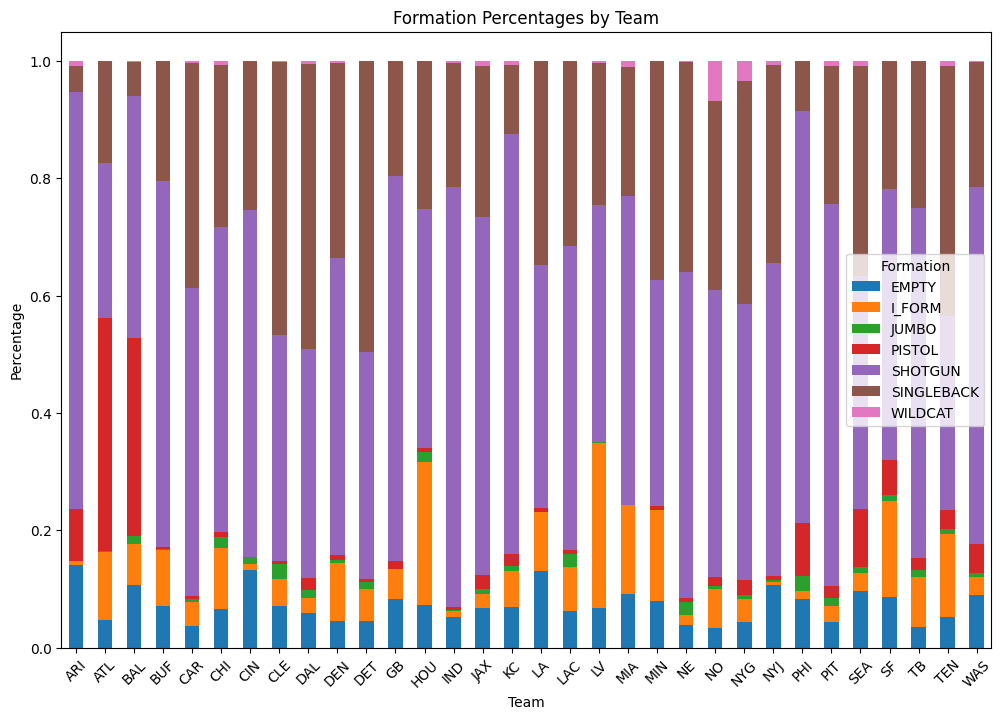

In [22]:
formation_pivot.plot(kind = 'bar', stacked = True, figsize = (12, 8))
plt.title('Formation Percentages by Team')
plt.ylabel('Percentage')
plt.xlabel('Team')
plt.xticks(rotation = 45)
plt.legend(title = 'Formation')
plt.show()

#### Team Offense Performance (Rush & Pass)

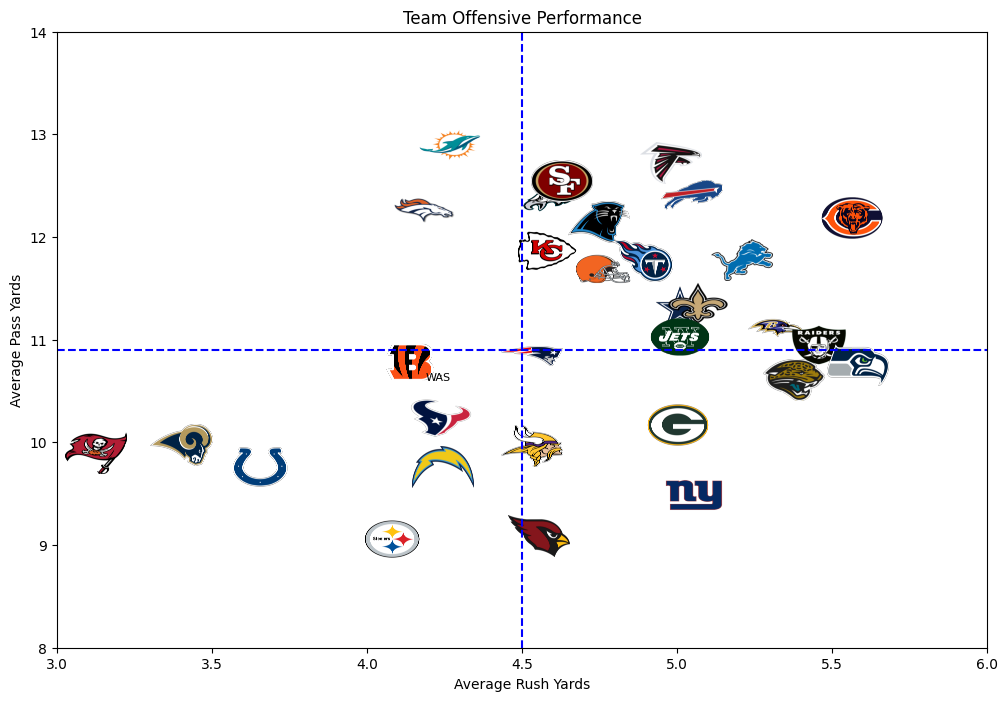

In [23]:
import matplotlib.image as mpimg
from adjustText import adjust_text

team_yards = yard_data_enh.groupby('teamAbbr').agg({'rushingYards': 'mean', 'receivingYards': 'mean'}).reset_index()

team_logos = {
    'ARI': 'logos/ARI.png',
    'ATL': 'logos/ATL.png',
    'BAL': 'logos/BAL.png',
    'BUF': 'logos/BUF.png',
    'CAR': 'logos/CAR.png',
    'CHI': 'logos/CHI.png',
    'CIN': 'logos/CIN.png',
    'CLE': 'logos/CLE.png',
    'DAL': 'logos/DAL.png',
    'DEN': 'logos/DEN.png',
    'DET': 'logos/DET.png',
    'GB': 'logos/GB.png',
    'HOU': 'logos/HOU.png',
    'IND': 'logos/IND.png',
    'JAX': 'logos/JAX.png',
    'KC': 'logos/KC.png',
    'LA': 'logos/LAR.png',
    'LAC': 'logos/LAC.png',
    'LV': 'logos/LV.png',
    'MIA': 'logos/MIA.png',
    'MIN': 'logos/MIN.png',
    'NE': 'logos/NE.png',
    'NO': 'logos/NOL.png',
    'NYG': 'logos/NYG.png',
    'NYJ': 'logos/NYJ.png',
    'PHI': 'logos/PHI.png',
    'PIT': 'logos/PIT.png', 
    'SEA': 'logos/SEA.png',
    'SF': 'logos/SF.png',
    'TB': 'logos/TB.png',
    'TEN': 'logos/TEN.png'
    }

fig, ax = plt.subplots(figsize = (12, 8))
texts = []

for _, row in team_yards.iterrows():
    team = row['teamAbbr']
    x = row['rushingYards']
    y = row['receivingYards']
    if team in team_logos:
        img = mpimg.imread(team_logos[team])
        ax.imshow(img, extent = (x - 0.1, x + 0.1, y - 0.2, y + 0.2), aspect = 'auto', zorder = 2)
    else:
        texts.append(ax.text(x, y, team, fontsize = 8, ha = 'center', va = 'center'))

ax.set_title('Team Offensive Performance')
ax.set_xlim(3, 6)
ax.set_ylim(8, 14)
ax.set_xlabel('Average Rush Yards')
ax.set_ylabel('Average Pass Yards')
ax.axhline(y = 10.9, color = 'b', linestyle = '--')
ax.axvline(x = 4.5, color = 'b', linestyle = '--')

adjust_text(texts, arrowprops = dict(arrowstyle = '->', color = 'gray'))
plt.show()

## Basic Models
Logisitic Regression predicting run versus pass
Player_play, plays, and player datasets

In [24]:
for row in range(len(yard_data_enh)):
    if pd.notnull(yard_data_enh.at[row, 'rushingYards']):
        yard_data_enh.at[row, 'rush'] = 1
    else:
        yard_data_enh.at[row, 'rush'] = 0
    #['rush'] = 0 if yard_data['rushingYards'].isna() else 1

In [25]:
categorical_variables = ['offenseFormation', 'teamAbbr', 'receiverAlignment']
target = 'rush'

X = yard_data_enh[categorical_variables]
y = yard_data_enh[target]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(), categorical_variables)]
)
# Basic Logistic Regression Model
log_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression())
    ]
)
# Fit the data
log_model.fit(X_train, y_train)
# Make a prediction
y_predict = log_model.predict(X_test)
# Accuracy
log_model_accuracy = accuracy_score(y_test, y_predict)


In [27]:
print(log_model_accuracy)

0.7064541213063764


In [28]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.68      0.74      0.70      1226
         1.0       0.74      0.68      0.71      1346

    accuracy                           0.71      2572
   macro avg       0.71      0.71      0.71      2572
weighted avg       0.71      0.71      0.71      2572



### Expanded Regression Model
The following fields have been added to our dataset. Let's see the results with this additional information. 

REMEMBER: It's useful to keep information that you can know with certainty before the play begins

'quarter', 'down', 'yardsToGo', 'preSnapHomeScore', 'preSnapVisitorScore', 'absoluteYardlineNumber'

In [29]:
for row in range(len(yard_data_enh)):
    if yard_data_enh.at[row, 'homeTeamAbbr'] == yard_data_enh.at[row, 'teamAbbr']:
        yard_data_enh.at[row, 'score_diff'] = yard_data_enh.at[row, 'preSnapHomeScore'] - yard_data_enh.at[row, 'preSnapVisitorScore']
    else:
        yard_data_enh.at[row, 'score_diff'] = yard_data_enh.at[row, 'preSnapVisitorScore'] - yard_data_enh.at[row, 'preSnapHomeScore']

In [30]:
for row in range(len(yard_data_enh)):
    if yard_data_enh.at[row, 'yardsToGo'] > 7: 
        yard_data_enh.at[row, 'yard_bucket'] = 'long'
    elif yard_data_enh.at[row, 'yardsToGo'] <= 2:
        yard_data_enh.at[row, 'yard_bucket'] = 'short'
    else:
        yard_data_enh.at[row, 'yard_bucket'] = 'mid'

In [31]:
for row in range(len(yard_data_enh)):
    if yard_data_enh.at[row, 'absoluteYardlineNumber'] > 50: 
        yard_data_enh.at[row, 'distance_bucket'] = 'long'
    elif yard_data_enh.at[row, 'absoluteYardlineNumber'] <= 20:
        yard_data_enh.at[row, 'distance_bucket'] = 'short'
    else:
        yard_data_enh.at[row,'distance_bucket'] = 'mid'

In [32]:
for row in range(len(yard_data_enh)):
    if yard_data_enh.at[row, 'quarter'] == 1:
        yard_data_enh.at[row, 'gameTimeRemaining'] = str(int(yard_data_enh.at[row, 'gameClock'][:2]) + 45) + yard_data_enh.at[row, 'gameClock'][3:]
    elif yard_data_enh.at[row, 'quarter'] == 2:
        yard_data_enh.at[row, 'gameTimeRemaining'] = str(int(yard_data_enh.at[row, 'gameClock'][:2]) + 30) + yard_data_enh.at[row, 'gameClock'][3:]
    elif yard_data_enh.at[row, 'quarter'] == 3:
        yard_data_enh.at[row, 'gameTimeRemaining'] = str(int(yard_data_enh.at[row, 'gameClock'][:2]) + 15) + yard_data_enh.at[row, 'gameClock'][3:]
    else:
        yard_data_enh.at[row, 'gameTimeRemaining'] = yard_data_enh.at[row, 'gameClock'][:2] + yard_data_enh.at[row, 'gameClock'][3:]

In [33]:
for row in range(len(yard_data_enh)):
    if int(yard_data_enh.at[row, 'gameTimeRemaining']) <= 200:
        yard_data_enh.at[row, 'time_bucket'] = 'FTMW'
    elif (int(yard_data_enh.at[row, 'gameTimeRemaining']) <= 3200) & (int(yard_data_enh.at[row, 'gameTimeRemaining']) >= 3001):
        yard_data_enh.at[row, 'time_bucket'] = 'HTMW'
    else:
        yard_data_enh.at[row, 'time_bucket'] = ''

In [34]:
yard_data_enh['time_bucket'].value_counts()

time_bucket
        11573
HTMW      762
FTMW      521
Name: count, dtype: int64

In [35]:
categorical_variables = ['offenseFormation', 'teamAbbr', 'receiverAlignment', 'quarter', 'down', 'yard_bucket', 'distance_bucket', 
                         'motionSinceLineset', 'time_bucket']
numeric_variables = ['score_diff']
variables = ['offenseFormation', 'teamAbbr', 'receiverAlignment', 'quarter', 'down', 'yard_bucket', 'distance_bucket', 'score_diff', 
             'motionSinceLineset', 'time_bucket']
target = 'rush'

X = yard_data_enh[variables]
y = yard_data_enh[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
# Basic Logistic Regression Model
log_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(solver = 'liblinear'))
    ]
)
# Fit the data
log_model.fit(X_train, y_train)
# Make a prediction
y_predict = log_model.predict(X_test)
# Accuracy
log_model_accuracy = accuracy_score(y_test, y_predict)

In [36]:
print(log_model_accuracy)

0.7414463452566097


In [37]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73      1226
         1.0       0.75      0.75      0.75      1346

    accuracy                           0.74      2572
   macro avg       0.74      0.74      0.74      2572
weighted avg       0.74      0.74      0.74      2572



#### Logistics Regression with Player Information

In [38]:
categorical_variables = ['offenseFormation', 'teamAbbr', 'receiverAlignment', 'quarter', 'down', 'yard_bucket', 'distance_bucket', 
                         'motionSinceLineset', 'time_bucket', 'player_1', 'player_2', 'player_3', 'player_4', 'player_5', 'player_6',
                         'player_7', 'player_8', 'player_9', 'player_10', 'player_11']
numeric_variables = ['score_diff']
variables = ['offenseFormation', 'teamAbbr', 'receiverAlignment', 'quarter', 'down', 'yard_bucket', 'distance_bucket', 'score_diff', 
             'motionSinceLineset', 'time_bucket', 'player_1', 'player_2', 'player_3', 'player_4', 'player_5', 'player_6',
                         'player_7', 'player_8', 'player_9', 'player_10', 'player_11']
target = 'rush'

X = yard_data_enh[variables]
y = yard_data_enh[target]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
# Basic Logistic Regression Model
log_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(solver = 'liblinear'))
    ]
)
# Fit the data
log_model.fit(X_train, y_train)
# Make a prediction
y_predict = log_model.predict(X_test)
# Accuracy
log_model_accuracy = accuracy_score(y_test, y_predict)

In [40]:
print(log_model_accuracy)

0.7391135303265941


### Logisitic Regression
Treat yardsToGo and absolutedistance as numerics

In [41]:
categorical_variables = ['offenseFormation', 'teamAbbr', 'receiverAlignment', 'quarter', 'down', 'motionSinceLineset', 'time_bucket']
numeric_variables = ['score_diff', 'yardsToGo', 'absoluteYardlineNumber']
variables = ['offenseFormation', 'teamAbbr', 'receiverAlignment', 'quarter', 'down', 'score_diff', 'yardsToGo', 'absoluteYardlineNumber', 
             'motionSinceLineset', 'time_bucket']
target = 'rush'

X = yard_data_enh[variables]
y = yard_data_enh[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
# Basic Logistic Regression Model
log_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(solver = 'liblinear'))
    ]
)
# Fit the data
log_model.fit(X_train, y_train)
# Make a prediction
y_predict = log_model.predict(X_test)
# Accuracy
log_model_accuracy = accuracy_score(y_test, y_predict)

In [42]:
print(log_model_accuracy)

0.7437791601866252


In [43]:
categorical_variables = ['offenseFormation', 'teamAbbr', 'receiverAlignment', 'quarter', 'down', 'motionSinceLineset', 'time_bucket', 
                         'player_1', 'player_2', 'player_3', 'player_4', 'player_5', 'player_6',
                         'player_7', 'player_8', 'player_9', 'player_10', 'player_11']
numeric_variables = ['score_diff', 'yardsToGo', 'absoluteYardlineNumber']
variables = ['offenseFormation', 'teamAbbr', 'receiverAlignment', 'quarter', 'down', 'score_diff', 'yardsToGo', 'absoluteYardlineNumber', 
             'motionSinceLineset', 'time_bucket', 'player_1', 'player_2', 'player_3', 'player_4', 'player_5', 'player_6',
                         'player_7', 'player_8', 'player_9', 'player_10', 'player_11']
target = 'rush'

X = yard_data_enh[variables]
y = yard_data_enh[target]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
# Basic Logistic Regression Model
log_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(solver = 'liblinear'))
    ]
)
# Fit the data
log_model.fit(X_train, y_train)
# Make a prediction
y_predict = log_model.predict(X_test)
# Accuracy
log_model_accuracy = accuracy_score(y_test, y_predict)

In [45]:
print(log_model_accuracy)

0.7379471228615864


### Random Forests Output
Now let's try a model with stronger predictive power, but lower explanability

In [46]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
## Random Forest Model
rf_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', RandomForestClassifier(n_estimators = 100, random_state = 42))
    ]
)

## Fit the data
rf_model.fit(X_train, y_train)

## Make a prediction
y_predict = rf_model.predict(X_test)

## Accuracy
rf_model_accuracy = accuracy_score(y_test, y_predict)

In [47]:
print(rf_model_accuracy)

0.744556765163297


0.744556765163297 Random Forests with players data

0.7356143079315708 Random Forests without players data

### Support Vector Machines

In [48]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
## Support Vector Machine Model
svc_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', SVC(kernel = 'linear', random_state = 42))
    ]
)

## Fit the data
svc_model.fit(X_train, y_train)

## Make a prediction
y_predict = svc_model.predict(X_test)

## Accuracy
svc_model_accuracy = accuracy_score(y_test, y_predict)

In [49]:
print(svc_model_accuracy)

0.7286158631415242


In [50]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.71      0.72      0.72      1226
         1.0       0.74      0.73      0.74      1346

    accuracy                           0.73      2572
   macro avg       0.73      0.73      0.73      2572
weighted avg       0.73      0.73      0.73      2572



0.7286158631415242 SVM with player data

0.7037325038880249 SVM without player data

## Route Predictions

In [51]:
for row in range(len(yard_data_enh)):
    if yard_data_enh.at[row, 'homeTeamAbbr'] == yard_data_enh.at[row, 'teamAbbr']:
        yard_data_enh.at[row, 'defTeam'] = yard_data_enh.at[row, 'visitorTeamAbbr']
    else:
        yard_data_enh.at[row, 'defTeam'] = yard_data_enh.at[row, 'homeTeamAbbr']

In [52]:
all_player_play = player_play[['gameId', 'playId', 'nflId']]
receiver_data = player_play[player_play['wasRunningRoute'] == 1][['gameId', 'playId', 'nflId', 'routeRan']]
player_position_data = players[['nflId', 'position']]
receiver_data_pos = pd.merge(receiver_data, player_position_data, on = ['nflId'], how = 'left')

In [53]:
player_pos = pd.merge(all_player_play, player_position_data, on = ['nflId'], how = 'left')
offensive_summary = player_pos.groupby(['gameId', 'playId']).agg(
    WR = ('position', lambda x: (x == 'WR').sum()),
    TE = ('position', lambda x: (x == 'TE').sum()),
    RB = ('position', lambda x: (x == 'RB').sum()),
).reset_index()

In [54]:
defender_summary = player_pos.groupby(['gameId', 'playId']).agg(
    CB = ('position', lambda x: (x == 'CB').sum()),
    ILB = ('position', lambda x: (x == 'ILB').sum()),
    OLB = ('position', lambda x: (x == 'OLB').sum()),
    DE = ('position', lambda x: (x == 'DE').sum()),
    DT = ('position', lambda x: (x == 'DT').sum()),
    NT = ('position', lambda x: (x == 'NT').sum()),
    FS = ('position', lambda x: (x == 'FS').sum()),
    SS = ('position', lambda x: (x == 'SS').sum()),
).reset_index()

In [55]:
receiver_data_summary = pd.merge(receiver_data_pos, offensive_summary, on = ['gameId', 'playId'], how = 'left')
receiver_defender_summary = pd.merge(receiver_data_summary, defender_summary[['gameId', 'playId', 'CB', 'ILB', 'OLB', 'DE', 'DT', 'FS', 'SS']], on = ['gameId', 'playId'])
receiver_def_data = pd.merge(receiver_defender_summary, yard_data_enh, how = 'inner', on = ['gameId', 'playId'])
receiver_def_data.rename(columns = {'nflId_x': 'nflId'}, inplace = True)

In [56]:
receiver_data_enh = pd.merge(receiver_def_data, plays[['gameId', 'playId', 'pff_passCoverage', 'pff_manZone']], on = ['gameId', 'playId'], how = 'left')

In [57]:
receiver_data_enh

,gameId,playId,nflId,routeRan,position,WR,TE,RB,CB,ILB,...,player_11,rush,score_diff,yard_bucket,distance_bucket,gameTimeRemaining,time_bucket,defTeam,pff_passCoverage,pff_manZone
0,2022090800,56,42489,IN,WR,3,1,1,2,2,...,53522,0.0,0.0,long,long,6000,,LA,Cover 6-Left,Zone
1,2022090800,56,44985,OUT,WR,3,1,1,2,2,...,53522,0.0,0.0,long,long,6000,,LA,Cover 6-Left,Zone
2,2022090800,56,47879,IN,TE,3,1,1,2,2,...,53522,0.0,0.0,long,long,6000,,LA,Cover 6-Left,Zone
3,2022090800,56,52536,GO,WR,3,1,1,2,2,...,53522,0.0,0.0,long,long,6000,,LA,Cover 6-Left,Zone
4,2022090800,122,42489,GO,WR,3,1,1,3,1,...,53522,0.0,0.0,mid,long,5815,,LA,Cover-3,Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28715,2022110700,3480,44879,FLAT,RB,3,1,1,2,2,...,54476,0.0,-21.0,long,long,0422,,BAL,Cover-3,Zone
28716,2022110700,3480,46160,IN,WR,3,1,1,2,2,...,54476,0.0,-21.0,long,long,0422,,BAL,Cover-3,Zone
28717,2022110700,3480,52942,OUT,TE,3,1,1,2,2,...,54476,0.0,-21.0,long,long,0422,,BAL,Cover-3,Zone
28718,2022110700,3480,53098,IN,WR,3,1,1,2,2,...,54476,0.0,-21.0,long,long,0422,,BAL,Cover-3,Zone


In [58]:
receiver_data_enh[['offenseFormation', 'routeRan']]

,offenseFormation,routeRan
0,SHOTGUN,IN
1,SHOTGUN,OUT
2,SHOTGUN,IN
3,SHOTGUN,GO
4,SHOTGUN,GO
...,...,...
28715,SHOTGUN,FLAT
28716,SHOTGUN,IN
28717,SHOTGUN,OUT
28718,SHOTGUN,IN


### Visualization: Routes Run by Formation

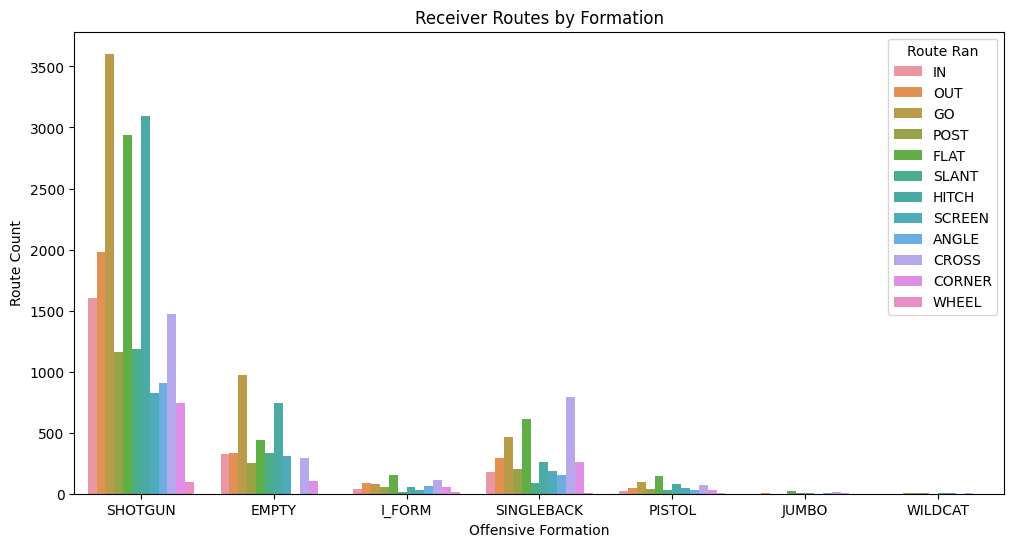

In [59]:
plt.figure(figsize = (12, 6))
sns.countplot(data = receiver_data_enh, x = 'offenseFormation', hue = 'routeRan')
plt.title('Receiver Routes by Formation')
plt.xlabel('Offensive Formation')
plt.ylabel('Route Count')
plt.legend(title = 'Route Ran')
plt.show()

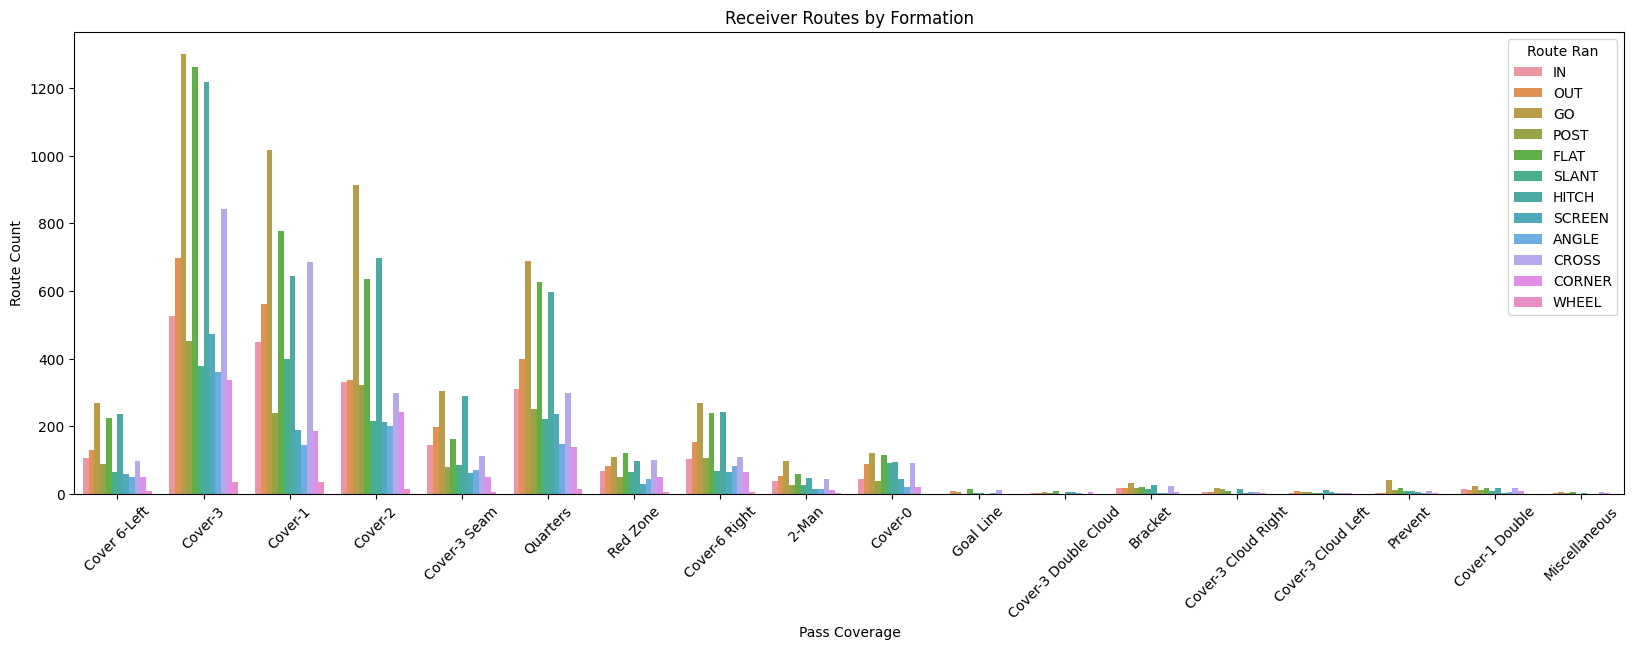

In [60]:
plt.figure(figsize = (20, 6))
sns.countplot(data = receiver_data_enh, x = 'pff_passCoverage', hue = 'routeRan')
plt.title('Receiver Routes by Formation')
plt.xlabel('Pass Coverage')
plt.xticks(rotation = 45)
plt.ylabel('Route Count')
plt.legend(title = 'Route Ran')
plt.show()

## Logisitic Regression Model
This should no longer predict will because we are NOT in a binary situation (i.e. no longer run versus pass)

In [61]:
categorical_variables = ['nflId', 'position', 'offenseFormation', 'teamAbbr', 'defTeam', 'receiverAlignment', 'quarter', 'down', 
                         'motionSinceLineset', 'time_bucket', 'WR', 'TE', 'RB', 'CB', 'ILB', 'OLB', 'DE', 'DT', 'FS', 'SS']
numeric_variables = ['score_diff', 'yardsToGo', 'absoluteYardlineNumber']
variables = ['nflId', 'position', 'offenseFormation', 'teamAbbr', 'defTeam', 'receiverAlignment', 'quarter', 'down', 'score_diff', 
             'yardsToGo', 'absoluteYardlineNumber', 'motionSinceLineset', 'time_bucket', 
             'WR', 'TE', 'RB', 'CB', 'ILB', 'OLB', 'DE', 'DT', 'FS', 'SS']
target = 'routeRan'

X = receiver_data_enh[variables]
y = receiver_data_enh[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
# Basic Logistic Regression Model
log_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(solver = 'liblinear'))
    ]
)
# Fit the data
log_model.fit(X_train, y_train)
# Make a prediction
y_predict = log_model.predict(X_test)
# Accuracy
log_model_accuracy = accuracy_score(y_test, y_predict)

In [62]:
print(log_model_accuracy)

0.296483286908078


In [63]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       ANGLE       0.36      0.10      0.16       237
      CORNER       0.16      0.01      0.02       255
       CROSS       0.25      0.32      0.28       522
        FLAT       0.45      0.65      0.54       858
          GO       0.29      0.58      0.38      1065
       HITCH       0.21      0.31      0.25       848
          IN       0.20      0.04      0.07       450
         OUT       0.21      0.06      0.10       540
        POST       0.17      0.02      0.03       366
      SCREEN       0.18      0.01      0.02       265
       SLANT       0.09      0.02      0.03       316
       WHEEL       0.00      0.00      0.00        22

    accuracy                           0.30      5744
   macro avg       0.21      0.18      0.16      5744
weighted avg       0.26      0.30      0.24      5744



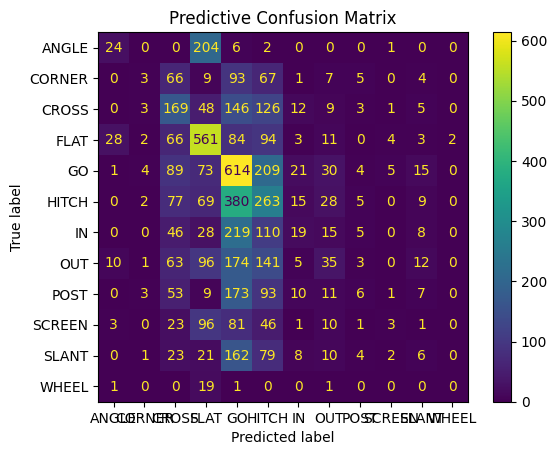

In [64]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_predict)
plt.title('Predictive Confusion Matrix')
plt.show()

### SVC

In [65]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
## Support Vector Machine Model
svc_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', SVC(kernel = 'linear', random_state = 42))
    ]
)

## Fit the data
svc_model.fit(X_train, y_train)

## Make a prediction
y_predict = svc_model.predict(X_test)

## Accuracy
svc_model_accuracy = accuracy_score(y_test, y_predict)

In [66]:
print(svc_model_accuracy)

0.2905640668523677


In [67]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       ANGLE       0.34      0.05      0.09       237
      CORNER       0.00      0.00      0.00       255
       CROSS       0.24      0.32      0.27       522
        FLAT       0.45      0.67      0.54       858
          GO       0.27      0.59      0.37      1065
       HITCH       0.21      0.30      0.25       848
          IN       0.16      0.02      0.04       450
         OUT       0.18      0.02      0.04       540
        POST       0.06      0.00      0.01       366
      SCREEN       0.60      0.01      0.02       265
       SLANT       0.18      0.01      0.02       316
       WHEEL       0.00      0.00      0.00        22

    accuracy                           0.29      5744
   macro avg       0.22      0.17      0.14      5744
weighted avg       0.25      0.29      0.22      5744



C:\Users\jlmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jlmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jlmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: Unde

### Random Forest Predictions

In [68]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
## Random Forest Model
rf_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', RandomForestClassifier(n_estimators = 100, random_state = 42))
    ]
)

## Fit the data
rf_model.fit(X_train, y_train)

## Make a prediction
y_predict = rf_model.predict(X_test)

## Accuracy
rf_model_accuracy = accuracy_score(y_test, y_predict)

In [69]:
print(rf_model_accuracy)

0.272458217270195


In [70]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       ANGLE       0.36      0.11      0.17       237
      CORNER       0.07      0.04      0.05       255
       CROSS       0.21      0.24      0.22       522
        FLAT       0.45      0.66      0.53       858
          GO       0.29      0.35      0.32      1065
       HITCH       0.26      0.33      0.29       848
          IN       0.13      0.10      0.12       450
         OUT       0.13      0.09      0.11       540
        POST       0.11      0.07      0.09       366
      SCREEN       0.10      0.06      0.08       265
       SLANT       0.23      0.17      0.20       316
       WHEEL       0.20      0.05      0.07        22

    accuracy                           0.27      5744
   macro avg       0.21      0.19      0.19      5744
weighted avg       0.24      0.27      0.25      5744



### Models with Player Data

### Logisitic Regression

In [71]:
categorical_variables = ['nflId', 'offenseFormation', 'teamAbbr', 'receiverAlignment', 'quarter', 'down', 'motionSinceLineset', 'time_bucket', 
                         'player_1', 'player_2', 'player_3', 'player_4', 'player_5', 'player_6',
                         'player_7', 'player_8', 'player_9', 'player_10', 'player_11', 
                         'WR', 'TE', 'RB', 'CB', 'ILB', 'OLB', 'DE', 'DT', 'FS', 'SS']
numeric_variables = ['score_diff', 'yardsToGo', 'absoluteYardlineNumber']
variables = ['nflId', 'offenseFormation', 'teamAbbr', 'receiverAlignment', 'quarter', 'down', 'score_diff', 'yardsToGo', 'absoluteYardlineNumber', 
             'motionSinceLineset', 'time_bucket', 'player_1', 'player_2', 'player_3', 'player_4', 'player_5', 'player_6',
                         'player_7', 'player_8', 'player_9', 'player_10', 'player_11',
                         'WR', 'TE', 'RB', 'CB', 'ILB', 'OLB', 'DE', 'DT', 'FS', 'SS']
target = 'routeRan'

X = receiver_data_enh[variables]
y = receiver_data_enh[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
# Basic Logistic Regression Model
log_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(solver = 'liblinear'))
    ]
)
# Fit the data
log_model.fit(X_train, y_train)
# Make a prediction
y_predict = log_model.predict(X_test)
# Accuracy
log_model_accuracy = accuracy_score(y_test, y_predict)

In [72]:
print(log_model_accuracy)

0.27942200557103064


In [73]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       ANGLE       0.28      0.12      0.17       237
      CORNER       0.14      0.05      0.07       255
       CROSS       0.23      0.27      0.25       522
        FLAT       0.44      0.59      0.50       858
          GO       0.29      0.47      0.36      1065
       HITCH       0.23      0.34      0.28       848
          IN       0.14      0.06      0.08       450
         OUT       0.18      0.11      0.14       540
        POST       0.11      0.04      0.05       366
      SCREEN       0.15      0.05      0.07       265
       SLANT       0.16      0.07      0.10       316
       WHEEL       0.00      0.00      0.00        22

    accuracy                           0.28      5744
   macro avg       0.20      0.18      0.17      5744
weighted avg       0.24      0.28      0.25      5744



### SVC

In [74]:
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
## Support Vector Machine Model
svc_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', SVC(kernel = 'linear', random_state = 42))
    ]
)

## Fit the data
svc_model.fit(X_train, y_train)

## Make a prediction
y_predict = svc_model.predict(X_test)

## Accuracy
svc_model_accuracy = accuracy_score(y_test, y_predict)

In [75]:
print(svc_model_accuracy)

0.2684540389972145


In [76]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       ANGLE       0.27      0.20      0.23       237
      CORNER       0.12      0.05      0.07       255
       CROSS       0.22      0.26      0.24       522
        FLAT       0.41      0.53      0.46       858
          GO       0.28      0.49      0.36      1065
       HITCH       0.23      0.31      0.26       848
          IN       0.18      0.07      0.10       450
         OUT       0.15      0.08      0.10       540
        POST       0.10      0.02      0.04       366
      SCREEN       0.16      0.03      0.06       265
       SLANT       0.12      0.04      0.06       316
       WHEEL       0.00      0.00      0.00        22

    accuracy                           0.27      5744
   macro avg       0.19      0.17      0.17      5744
weighted avg       0.23      0.27      0.24      5744



### Random Forest

In [77]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
## Random Forest Model
rf_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', RandomForestClassifier(n_estimators = 50, random_state = 42))
    ]
)

## Fit the data
rf_model.fit(X_train, y_train)

## Make a prediction
y_predict = rf_model.predict(X_test)

## Accuracy
rf_model_accuracy = accuracy_score(y_test, y_predict)

In [78]:
print(rf_model_accuracy)

0.19411559888579388


In [79]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       ANGLE       0.10      0.05      0.07       237
      CORNER       0.04      0.04      0.04       255
       CROSS       0.19      0.24      0.21       522
        FLAT       0.26      0.27      0.27       858
          GO       0.24      0.29      0.26      1065
       HITCH       0.23      0.26      0.25       848
          IN       0.12      0.10      0.11       450
         OUT       0.15      0.14      0.14       540
        POST       0.06      0.04      0.05       366
      SCREEN       0.10      0.08      0.09       265
       SLANT       0.18      0.17      0.17       316
       WHEEL       0.00      0.00      0.00        22

    accuracy                           0.19      5744
   macro avg       0.14      0.14      0.14      5744
weighted avg       0.18      0.19      0.19      5744



### Decision Tree Classifier


In [80]:
categorical_variables = ['nflId', 'offenseFormation', 'teamAbbr', 'defTeam', 'receiverAlignment', 'quarter', 'down', 
                         'motionSinceLineset', 'time_bucket', 'WR', 'TE', 'RB', 'CB', 'ILB', 'OLB', 'DE', 'DT', 'FS', 'SS']
numeric_variables = ['score_diff', 'yardsToGo', 'absoluteYardlineNumber']
variables = ['nflId', 'offenseFormation', 'teamAbbr', 'defTeam', 'receiverAlignment', 'quarter', 'down', 'score_diff', 
             'yardsToGo', 'absoluteYardlineNumber', 'motionSinceLineset', 'time_bucket', 
             'WR', 'TE', 'RB', 'CB', 'ILB', 'OLB', 'DE', 'DT', 'FS', 'SS']
target = 'routeRan'

X = receiver_data_enh[variables]
y = receiver_data_enh[target]

In [81]:
tb_data = receiver_data_enh[receiver_data_enh['teamAbbr'] == 'TB']
X = tb_data[variables]
y = tb_data[target]

In [82]:
from sklearn.tree import DecisionTreeClassifier
def decision_tree_testing(depth):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    ## One Hot Encode the categorical values
    preprocessing = ColumnTransformer(
        transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                        ], 
                        remainder = 'passthrough'
    )
    ## Random Forest Model
    dt_model = Pipeline(
        steps = [
            ('preprocessor', preprocessing),
            ('classifier', DecisionTreeClassifier(max_depth = depth, random_state = 42))
        ]
    )

    ## Fit the data
    dt_model.fit(X_train, y_train)

    ## Make a prediction
    y_predict = dt_model.predict(X_test)

    ## Accuracy
    dt_model_accuracy = accuracy_score(y_test, y_predict)
    return dt_model_accuracy

In [83]:
dt_results = {}
for i in range(5, 50):
    dt_results[i] =  decision_tree_testing(i)

<Axes: >

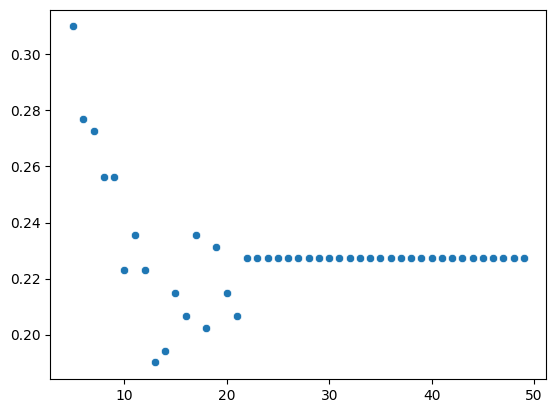

In [84]:
sns.scatterplot(dt_results)

In [85]:
dt_results

{5: 0.30991735537190085,
 6: 0.2768595041322314,
 7: 0.2727272727272727,
 8: 0.256198347107438,
 9: 0.256198347107438,
 10: 0.2231404958677686,
 11: 0.23553719008264462,
 12: 0.2231404958677686,
 13: 0.19008264462809918,
 14: 0.19421487603305784,
 15: 0.21487603305785125,
 16: 0.2066115702479339,
 17: 0.23553719008264462,
 18: 0.2024793388429752,
 19: 0.23140495867768596,
 20: 0.21487603305785125,
 21: 0.2066115702479339,
 22: 0.22727272727272727,
 23: 0.22727272727272727,
 24: 0.22727272727272727,
 25: 0.22727272727272727,
 26: 0.22727272727272727,
 27: 0.22727272727272727,
 28: 0.22727272727272727,
 29: 0.22727272727272727,
 30: 0.22727272727272727,
 31: 0.22727272727272727,
 32: 0.22727272727272727,
 33: 0.22727272727272727,
 34: 0.22727272727272727,
 35: 0.22727272727272727,
 36: 0.22727272727272727,
 37: 0.22727272727272727,
 38: 0.22727272727272727,
 39: 0.22727272727272727,
 40: 0.22727272727272727,
 41: 0.22727272727272727,
 42: 0.22727272727272727,
 43: 0.22727272727272727,
 4

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ], 
                    remainder = 'passthrough'
)
## Random Forest Model
dt_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', DecisionTreeClassifier(max_depth = 43, random_state = 42))
    ]
)

## Fit the data
dt_model.fit(X_train, y_train)

## Make a prediction
y_predict = dt_model.predict(X_test)

## Accuracy
dt_model_accuracy = accuracy_score(y_test, y_predict)

In [87]:
print(dt_model_accuracy)

0.22727272727272727


In [88]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       ANGLE       0.32      0.26      0.29        23
      CORNER       0.00      0.00      0.00         6
       CROSS       0.00      0.00      0.00         4
        FLAT       0.31      0.28      0.29        39
          GO       0.39      0.37      0.38        46
       HITCH       0.30      0.26      0.28        38
          IN       0.05      0.06      0.05        17
         OUT       0.16      0.19      0.17        27
        POST       0.12      0.14      0.13        14
      SCREEN       0.08      0.10      0.09        10
       SLANT       0.17      0.11      0.13        18
       WHEEL       0.00      0.00      0.00         0

    accuracy                           0.23       242
   macro avg       0.16      0.15      0.15       242
weighted avg       0.24      0.23      0.23       242



C:\Users\jlmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jlmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jlmer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarni

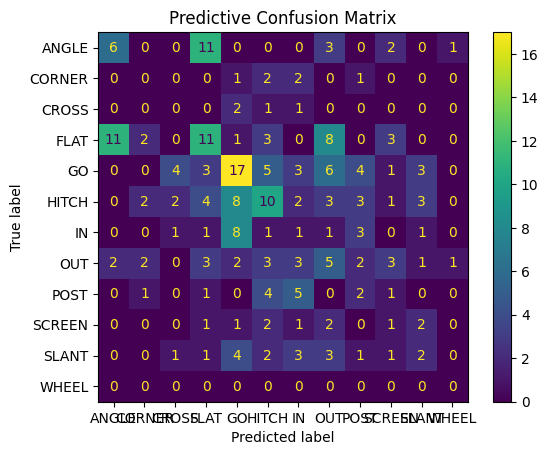

In [89]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_predict)
plt.title('Predictive Confusion Matrix')
plt.show()

In [90]:
from sklearn.tree import export_text, plot_tree

print('Decision Tree Rules:')
print(export_text(dt_model.named_steps['classifier'], feature_names = preprocessing.get_feature_names_out().tolist()))

Decision Tree Rules:
|--- cat__nflId_44816 <= 0.50
|   |--- cat__nflId_54556 <= 0.50
|   |   |--- cat__nflId_44896 <= 0.50
|   |   |   |--- cat__receiverAlignment_2x2 <= 0.50
|   |   |   |   |--- cat__WR_2 <= 0.50
|   |   |   |   |   |--- remainder__score_diff <= -5.50
|   |   |   |   |   |   |--- remainder__score_diff <= -9.00
|   |   |   |   |   |   |   |--- cat__defTeam_KC <= 0.50
|   |   |   |   |   |   |   |   |--- cat__DE_2 <= 0.50
|   |   |   |   |   |   |   |   |   |--- cat__nflId_54571 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- remainder__absoluteYardlineNumber <= 56.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- remainder__absoluteYardlineNumber >  56.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 6
|   |   |   |   |   |   |   |   |   |--- cat__nflId_54571 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- cat__DT_1 <= 0.50
|   |   |   |   |   |   |   |   |

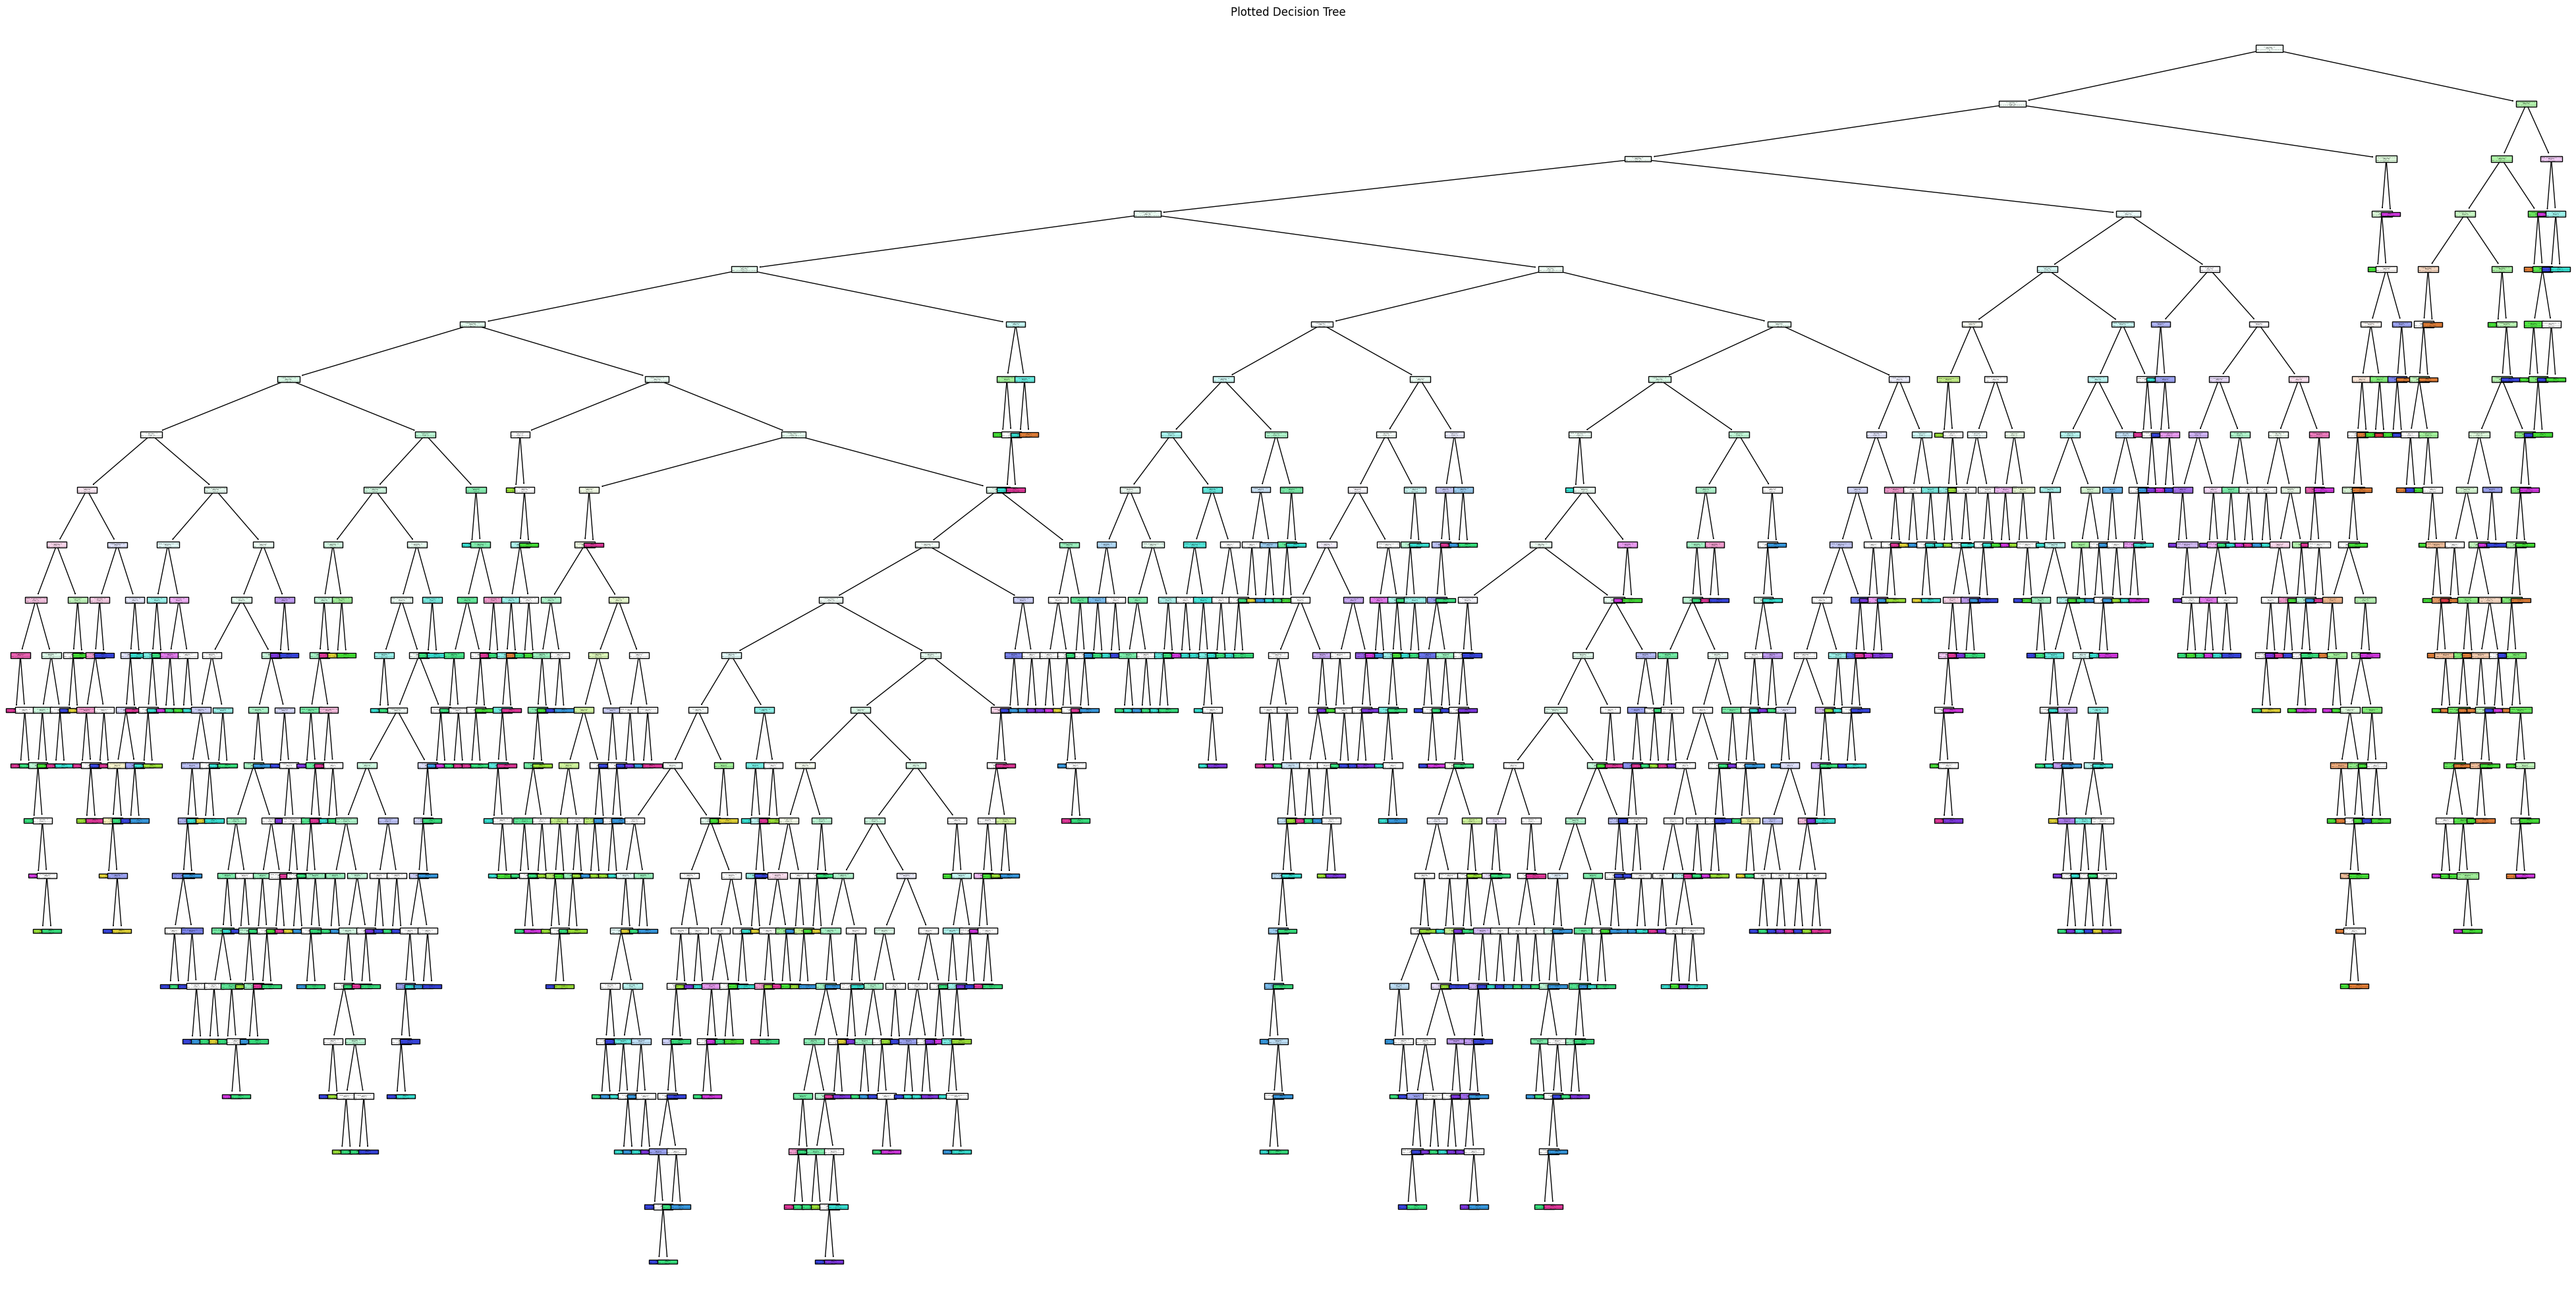

In [91]:
plt.figure(figsize = (50, 25))
plot_tree(dt_model.named_steps['classifier'], feature_names = preprocessing.get_feature_names_out().tolist(), class_names = dt_model.named_steps['classifier'].classes_, filled = True)
plt.title('Plotted Decision Tree')
plt.show()

## Revisiting Run Versus Pass
Logistic and Decisition with updated fields for players
TODO: Go back and add position counts to the player_data_enh dataset

In [92]:
rush_off_data = pd.merge(yard_data_enh, offensive_summary, on = ['gameId', 'playId'], how = 'left')
rush_def_data = pd.merge(rush_off_data, defender_summary[['gameId', 'playId', 'CB', 'ILB', 'OLB', 'DE', 'DT', 'FS', 'SS']], on = ['gameId', 'playId'])
rush_def_data.rename(columns = {'nflId_x': 'nflId'}, inplace = True)                 

In [93]:
rush_def_data

,nflId,gameId,playId,teamAbbr,rushingYards,displayName,offenseFormation,receivingYards,passResult,receiverAlignment,...,WR,TE,RB,CB,ILB,OLB,DE,DT,FS,SS
0,25511,2022091804,576,TB,0.0,Tom Brady,SINGLEBACK,NaN,NaN,2x2,...,3,1,1,2,0,2,1,2,3,0
1,37101,2022091804,80,NO,8.0,Mark Ingram,SINGLEBACK,NaN,NaN,2x2,...,2,2,1,2,2,2,1,1,2,0
2,37101,2022091804,112,NO,12.0,Mark Ingram,JUMBO,NaN,NaN,2x1,...,1,2,1,2,2,2,1,1,2,0
3,37101,2022091804,197,NO,3.0,Mark Ingram,SINGLEBACK,NaN,NaN,3x1,...,3,1,1,2,2,2,0,1,3,0
4,37101,2022091804,678,NO,3.0,Mark Ingram,I_FORM,NaN,NaN,2x1,...,1,2,1,2,2,2,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12851,53444,2022103007,2976,NE,NaN,Mac Jones,SHOTGUN,NaN,S,2x2,...,3,1,1,3,2,0,2,2,0,2
12852,53444,2022103007,3005,NE,NaN,Mac Jones,SHOTGUN,6.0,C,2x2,...,3,1,1,3,2,0,2,1,0,2
12853,53444,2022103007,3243,NE,NaN,Mac Jones,SINGLEBACK,4.0,C,2x2,...,3,1,1,3,1,1,2,1,0,2
12854,53444,2022103007,3531,NE,NaN,Mac Jones,SHOTGUN,NaN,S,2x2,...,3,1,1,3,1,1,2,2,0,2


In [94]:
categorical_variables = ['offenseFormation', 'teamAbbr', 'defTeam', 'receiverAlignment', 'quarter', 'down', 
                         'motionSinceLineset', 'time_bucket', 'WR', 'TE', 'RB', 'CB', 'ILB', 'OLB', 'DE', 'DT', 'FS', 'SS']
numeric_variables = ['score_diff', 'yardsToGo', 'absoluteYardlineNumber']
variables = ['offenseFormation', 'teamAbbr', 'defTeam', 'receiverAlignment', 'quarter', 'down', 'score_diff', 
             'yardsToGo', 'absoluteYardlineNumber', 'motionSinceLineset', 'time_bucket', 
             'WR', 'TE', 'RB', 'CB', 'ILB', 'OLB', 'DE', 'DT', 'FS', 'SS']
target = 'rush'

X = rush_def_data[variables]
y = rush_def_data[target]

### Logistic Regression

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
# Basic Logistic Regression Model
log_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(solver = 'liblinear'))
    ]
)
# Fit the data
log_model.fit(X_train, y_train)
# Make a prediction
y_predict = log_model.predict(X_test)
# Accuracy
log_model_accuracy = accuracy_score(y_test, y_predict)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_predict)
plt.title('Predictive Confusion Matrix')
plt.show()

In [ ]:
print(log_model_accuracy)

In [ ]:
print(classification_report(y_test, y_predict))

In [ ]:
# Get the model and its steps
logistic_regression_model = log_model.named_steps['classifier']
preprocessor = log_model.named_steps['preprocessor']

categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_variables)
all_features = list(categorical_features) + numeric_variables

coefficents = logistic_regression_model.coef_[0]
intercepts = logistic_regression_model.intercept_[0]

log_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficents
}).sort_values(by = 'Coefficient', key = abs, ascending = False)

In [132]:
rush_def_data['teamAbbr'].value_counts()

teamAbbr
IND    467
ARI    456
WAS    448
CIN    448
JAX    439
NO     438
NE     437
GB     434
ATL    431
CHI    430
PHI    424
TB     424
CLE    421
BAL    415
NYJ    410
KC     408
MIA    407
NYG    389
SEA    384
LAC    384
PIT    382
MIN    378
DET    377
DEN    375
LA     373
SF     368
LV     359
BUF    356
DAL    354
TEN    350
CAR    349
HOU    341
Name: count, dtype: int64

In [119]:
rush_def_data['offenseFormation'].unique()

array(['SINGLEBACK', 'JUMBO', 'I_FORM', 'PISTOL', 'SHOTGUN', 'EMPTY',
       'WILDCAT'], dtype=object)

In [155]:
categorical_variables = ['offenseFormation', 'defTeam', 'receiverAlignment', 'quarter', 'down', 
                         'motionSinceLineset', 'time_bucket', 'WR', 'TE', 'RB']
numeric_variables = ['score_diff', 'yardsToGo', 'absoluteYardlineNumber']
variables = ['offenseFormation', 'defTeam', 'receiverAlignment', 'quarter', 'down', 'score_diff', 
             'yardsToGo', 'absoluteYardlineNumber', 'motionSinceLineset', 'time_bucket', 
             'WR', 'TE', 'RB']
target = 'rush'

TB = rush_def_data[rush_def_data['teamAbbr'] == 'TB']

X = TB[variables]
y = TB[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
# Basic Logistic Regression Model
log_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(solver = 'liblinear'))
    ]
)
# Fit the data
log_model.fit(X_train, y_train)
# Make a prediction
y_predict = log_model.predict(X_test)
# Accuracy
log_model_accuracy = accuracy_score(y_test, y_predict)

In [156]:
print(log_model_accuracy)

0.8235294117647058


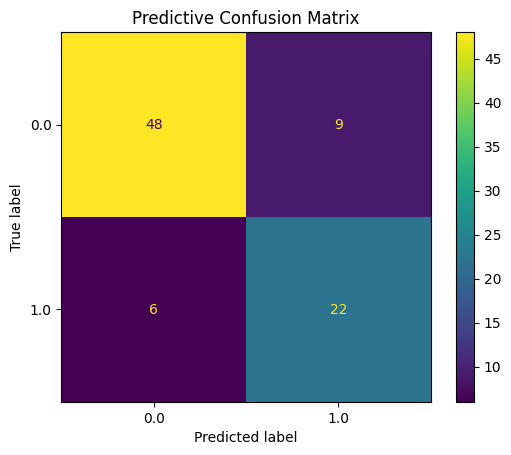

In [157]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_predict)
plt.title('Predictive Confusion Matrix')
plt.show()

In [158]:
# Get the model and its steps
logistic_regression_model = log_model.named_steps['classifier']
preprocessor = log_model.named_steps['preprocessor']

categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_variables)
all_features = list(categorical_features) + numeric_variables

coefficents = logistic_regression_model.coef_[0]
intercepts = logistic_regression_model.intercept_[0]

log_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficents
}).sort_values(by = 'Coefficient', key = abs, ascending = False)

In [159]:
log_df[0:20]

,Feature,Coefficient
4,offenseFormation_SHOTGUN,-1.625402
34,time_bucket_HTMW,-1.090017
0,offenseFormation_EMPTY,-1.051705
19,receiverAlignment_3x2,-1.018470
11,defTeam_KC,-0.996833
30,motionSinceLineset_1.0,-0.990098
31,motionSinceLineset_nan,0.972893
41,TE_0,-0.923558
13,defTeam_NO,0.896929
5,offenseFormation_SINGLEBACK,0.890243


In [129]:
categorical_variables = ['teamAbbr', 'defTeam', 'receiverAlignment', 'quarter', 'down', 
                         'motionSinceLineset', 'time_bucket']
numeric_variables = ['score_diff', 'yardsToGo', 'absoluteYardlineNumber']
variables = ['teamAbbr', 'defTeam', 'receiverAlignment', 'quarter', 'down', 'score_diff', 
             'yardsToGo', 'absoluteYardlineNumber', 'motionSinceLineset', 'time_bucket']
target = 'rush'

shotgun = rush_def_data[rush_def_data['offenseFormation'] == 'SHOTGUN']

X = shotgun[variables]
y = shotgun[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ('num', StandardScaler(), numeric_variables)
                    ]
)
# Basic Logistic Regression Model
log_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', LogisticRegression(solver = 'liblinear'))
    ]
)
# Fit the data
log_model.fit(X_train, y_train)
# Make a prediction
y_predict = log_model.predict(X_test)
# Accuracy
log_model_accuracy = accuracy_score(y_test, y_predict)

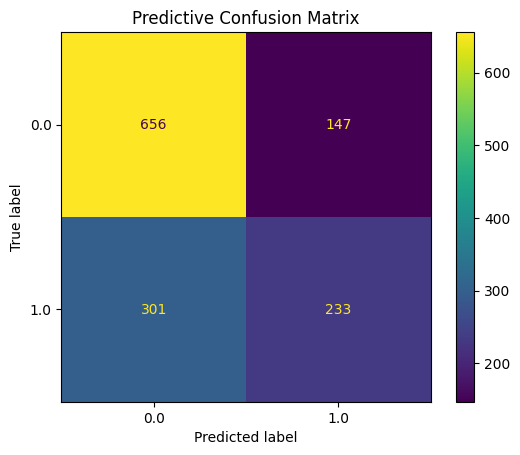

In [130]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_predict)
plt.title('Predictive Confusion Matrix')
plt.show()

In [131]:
print(log_model_accuracy)

0.6649214659685864


In [113]:
coeff_df_sorted = log_df.sort_values(by = 'Coefficient', ascending = False)

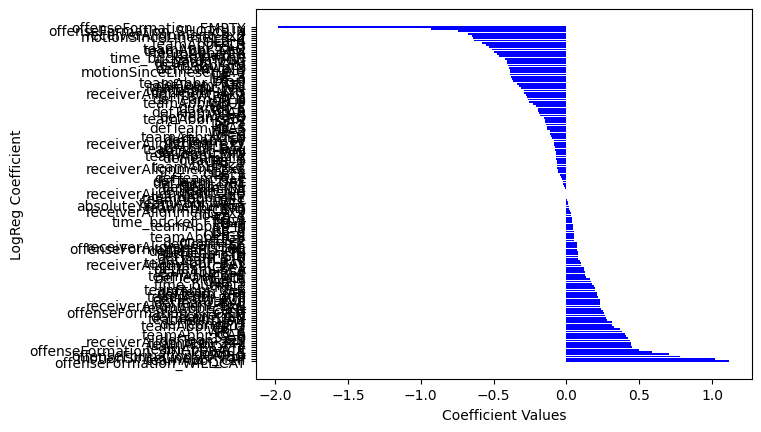

In [114]:
plt.barh(coeff_df_sorted['Feature'], coeff_df_sorted['Coefficient'], color = 'blue')
plt.xlabel('Coefficient Values')
plt.ylabel('LogReg Coefficient')
plt.show()

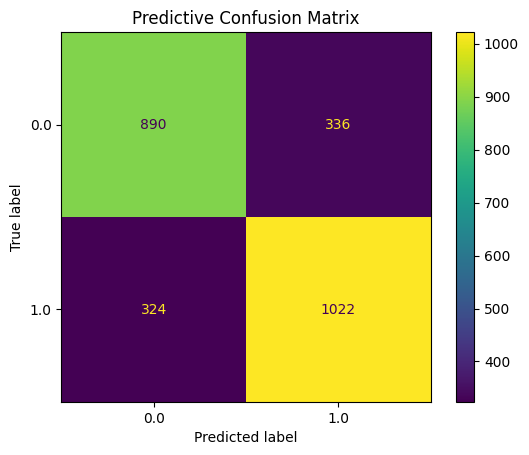

0.7433903576982893


              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73      1226
         1.0       0.75      0.76      0.76      1346

    accuracy                           0.74      2572
   macro avg       0.74      0.74      0.74      2572
weighted avg       0.74      0.74      0.74      2572



### Decision Tree

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
## One Hot Encode the categorical values
preprocessing = ColumnTransformer(
    transformers = [('cat', OneHotEncoder(handle_unknown = 'ignore'), categorical_variables),
                    ], 
                    remainder = 'passthrough'
)
## Random Forest Model
dt_model = Pipeline(
    steps = [
        ('preprocessor', preprocessing),
        ('classifier', DecisionTreeClassifier(max_depth = 25, random_state = 42))
    ]
)

## Fit the data
dt_model.fit(X_train, y_train)

## Make a prediction
y_predict = dt_model.predict(X_test)

## Accuracy
dt_model_accuracy = accuracy_score(y_test, y_predict)

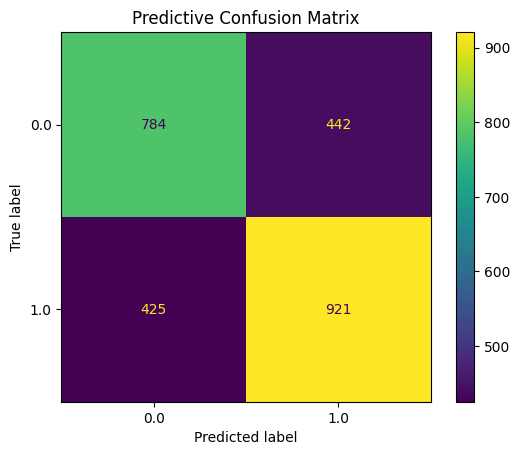

In [100]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_predict)
plt.title('Predictive Confusion Matrix')
plt.show()

In [101]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.65      0.64      0.64      1226
         1.0       0.68      0.68      0.68      1346

    accuracy                           0.66      2572
   macro avg       0.66      0.66      0.66      2572
weighted avg       0.66      0.66      0.66      2572

